# Исследование показов рекламы

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов: 
* int – полноэкранная реклама; 
* banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
* rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы.   

Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.

**Бизнес задача**

Провести исследование показов рекламы с целью понять на сколько
отличается eCPM в зависимости от географии (города) юзера, версии ОС и
других параметров. Интересны любые инсайты и находки по eCPM-ам.

В нашем распоряжении находится csv файл содержащий информацию о показах рекламы для юзеров США.

**Требуется:**

1. Для каждого формата рекламы:
  * построить распределение средних eCPM-ов юзеров 
  * отобразить средние eCPM-ы по городам, версиям ОС 
  * отобразить суммарные доходы по городам, версиям ОС 
2. Учесть статистическую значимость для п.1b (отобразить, отфильтровать
незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.

**Дополнительно исследовать:**

* Какой процент доходов содержит информацию о городе юзера 
* Зависит ли eCPM от времени дня

**Вспомогательная информация:**

*eCPM* – доход за 1000 показов рекламы.

Столбец `profile_id` – id юзера 

Столбец `event_json` содержит данные о событии показа рекламы:

 * `ad_type` – формат рекламы (int, banner или rv) 
 * `placement` – когда/где был показ рекламы в игре 
 * `view_index` – номер показа конкретного формата рекламы для юзера (не
поддерживается для баннеров) 
 * `revenue` – доход от конкретного показа рекламы (eCPM = revenue * 1000) 
 * `ads_ltv` – накапливающийся доход от рекламы, равен сумме всех revenue юзера 
 * `network_name` – рекламная сеть, от которой был показ \

Предобработка
Анализ данных
2.1 Распределение средних eCPM-ов юзеров
Полноэкранная реклама
Горизонтальный баннер
Видео (которое юзер смотрит по желанию)
Длинна и количество сессий юзеров
Вывод по разделу.
2.2 Средние eCPM-ы по городам.
Полноэкранная реклама
Горизонтальный баннер
Видео (которое юзер смотрит по желанию)
Вывод по разделу
2.3 Средние eCPM-ы по версиям ОС.
2.4 Суммарные доходы по городам
Полноэкранная реклама
Горизонтальный баннер
Видео (которое юзер смотрит по желанию)
Вывод по разделу
2.5 Суммарные доходы по версиям ОС
2.5 Средние eCPM-ы по городам с учетом статистической значимости.
Полноэкранная реклама
Горизонтальный баннер
Видео (которое юзер смотрит по желанию)
Заключение
3.1 Зависимость eCPM от времени суток.
Полноэкранная реклама
Горизонтальный баннер
Видео (которое юзер смотрит по желанию)


## 1. Предобработка

In [179]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [180]:
df = pd.read_csv('/content/drive/MyDrive/us events ad_revenue filtered 03.02-07.02.csv')

In [181]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Посмотрим на количество дубликатов в исходном дата-фрейме, а затем преобразуем его.

In [182]:
df.duplicated().sum()

0

Дублей объектов нет, движимся дальше.

Интересующие нас данные находятся в json-формате в столбце `event_json`. Pаспарсим данную информацию.

In [183]:
df_json = pd.io.json.json_normalize(df['event_json'].apply(json.loads))

In [184]:
df_json.head()

,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,banner,,1,0,637795729492245130,705.88070,0.000510,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,banner,,1,0,637795729659949790,722.65120,0.000510,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,banner,,1,0,637796515863735930,431.81290,0.002386,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,int,next_level,1,1,637797353426827330,125.94960,0.013894,0.013894,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,banner,,1,0,637797357392197840,12.71129,0.006828,0.060571,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


Присоединим получившуюся таблицу к исходной.

In [185]:
df_new = df.join(df_json)

In [186]:
df_new.head(3).T

,0,1,2
profile_id,JLjpGzDHBQm,JLjpGzDHBQm,JLkVacrzHY6
os_version,11,11,11
device_manufacturer,Samsung,Samsung,Google
device_model,Galaxy Tab S6,Galaxy Tab S6,Pixel 2
device_type,tablet,tablet,phone
device_locale,en_US,en_US,en_US
event_name,c_ad_revenue,c_ad_revenue,c_ad_revenue
event_json,"{""ad_type"":""banner"",""placement"":"""",""view_index...","{""ad_type"":""banner"",""placement"":"""",""view_index...","{""ad_type"":""banner"",""placement"":"""",""view_index..."
event_datetime,2022-02-04 20:02:28,2022-02-04 20:02:45,2022-02-05 17:53:05
event_timestamp,1643994148,1643994165,1644072785


Удалим лишние (дублирующие и не информативные) признаки из нашего нового дата-фрейма.





In [187]:
df_new.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json',
       'event_datetime', 'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'city', 'ad_type', 'placement', 'view_index',
       'session_view_index', 'cur_ticks', 'session_length', 'revenue',
       'ads_ltv', 'ecpm_sma', 'normalized_ecpm_sma', 'value', 'currency',
       'ad_country_code', 'network_name', 'ad_unit_id', 'ad_network_placement',
       'creativeId'],
      dtype='object')

In [188]:
df_new = df_new.drop(['device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json', 
       'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'placement', 'view_index',
       'session_view_index', 'cur_ticks',
       'ads_ltv', 'ecpm_sma', 'normalized_ecpm_sma', 'value',
       'ad_country_code', 'ad_unit_id', 'ad_network_placement','creativeId'], axis=1)

In [189]:
df_new.head()

,profile_id,os_version,event_datetime,city,ad_type,session_length,revenue,currency,network_name
0,JLjpGzDHBQm,11,2022-02-04 20:02:28,Norwalk,banner,705.88070,0.000510,USD,Google AdMob
1,JLjpGzDHBQm,11,2022-02-04 20:02:45,Norwalk,banner,722.65120,0.000510,USD,Google AdMob
2,JLkVacrzHY6,11,2022-02-05 17:53:05,Charlotte,banner,431.81290,0.002386,USD,APPLOVIN_EXCHANGE
3,JMC6wG3cX0f,10,2022-02-06 17:09:01,Cocoa,int,125.94960,0.013894,USD,AppLovin
4,JLzWWTJfi1b,10,2022-02-06 17:15:38,NaN,banner,12.71129,0.006828,USD,Google AdMob


In [190]:
df_new['currency'].unique()

array(['USD'], dtype=object)

Признак `currency` так же можно убрать из дата-фрейма, так как все суммы указаны в долларах.

In [191]:
df_new = df_new.drop('currency', axis=1)

Добавим новый признак `eCPM`.

In [192]:
df_new['eCPM'] = df_new['revenue'] * 1000

In [193]:
df_new.sample(5)

,profile_id,os_version,event_datetime,city,ad_type,session_length,revenue,network_name,eCPM
506980,JLe1d3coPO0,12,2022-02-04 07:29:26,Austin,rv,2455.2420,0.080640,Google AdMob,80.640000
430300,JLw0yF6UB5e,11,2022-02-05 19:56:57,Rochester,banner,2851.3020,0.000530,Google AdMob,0.530292
27425,JL5zpw9fezd,12,2022-02-04 11:27:58,Denver,banner,639.8768,0.000515,Google AdMob,0.515023
689719,JLotWAsh34E,12,2022-02-07 20:37:34,College Station,banner,11960.5400,0.000432,Google AdMob,0.432453
736424,JLRnheSoU0A,12,2022-02-07 04:29:34,Omaha,banner,7684.1220,0.000438,Google AdMob,0.437656


Отлично, в таблице только нужные для исследования признаки. Теперь взглянем на пропуски и дубликаты.

In [194]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   profile_id      860065 non-null  object 
 1   os_version      860079 non-null  object 
 2   event_datetime  860079 non-null  object 
 3   city            536371 non-null  object 
 4   ad_type         860079 non-null  object 
 5   session_length  860079 non-null  float64
 6   revenue         860079 non-null  float64
 7   network_name    860079 non-null  object 
 8   eCPM            860079 non-null  float64
dtypes: float64(3), object(6)
memory usage: 59.1+ MB


В датафрейме имеются пропуски. Посмотрим на их количество в процентном соотношении.

In [195]:
df_new.isna().mean()

profile_id        0.000016
os_version        0.000000
event_datetime    0.000000
city              0.376370
ad_type           0.000000
session_length    0.000000
revenue           0.000000
network_name      0.000000
eCPM              0.000000
dtype: float64

Более 37% доходов не содержат информации о городе пользователя. Заменим пропуски на `unknown`.

In [196]:
df_new['city'] = df_new['city'].fillna('unknown')

Так же отсутствуют несколько значений id profile. Так как их совсем не много - можно просто удалить пропуски в данном столбце.

In [197]:
df_new = df_new.dropna(subset = ['profile_id'])

In [198]:
df_new.isna().sum()

profile_id        0
os_version        0
event_datetime    0
city              0
ad_type           0
session_length    0
revenue           0
network_name      0
eCPM              0
dtype: int64

С пропусками разобрались, теперь приведём к нужному типу столбец `event_datetime`.

In [199]:
df_new['event_datetime'] = pd.to_datetime(df_new['event_datetime'])

In [200]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860065 entries, 0 to 860078
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   profile_id      860065 non-null  object        
 1   os_version      860065 non-null  object        
 2   event_datetime  860065 non-null  datetime64[ns]
 3   city            860065 non-null  object        
 4   ad_type         860065 non-null  object        
 5   session_length  860065 non-null  float64       
 6   revenue         860065 non-null  float64       
 7   network_name    860065 non-null  object        
 8   eCPM            860065 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 65.6+ MB


Дата-фрейм приведён к удобному для исследования виду, пропуски обработаны, типы данных соответствуют их значениям. Можно переходить к следующему шагу.

## 2. Анализ данных

### 2.1 Распределение средних eCPM-ов юзеров

#### Полноэкранная реклама


In [201]:
eCPM_mean_int = df_new[df_new['ad_type'] == 'int'].groupby('profile_id')['eCPM'].agg('mean').reset_index()
eCPM_mean_int

,profile_id,eCPM
0,JL015rw9vmN,21.983199
1,JL01aCdFTJy,11.965651
2,JL04ODuw9UP,23.160000
3,JL06b4k4ygp,7.327454
4,JL06eD8uPpv,44.820000
...,...,...
3957,JMLQTj4i34Y,18.723556
3958,JMLY5SO7wmn,30.015743
3959,JMLmauy744E,23.429988
3960,JMLt54Rmui5,23.706346


In [202]:
eCPM_mean_int['eCPM'].describe()

count    3962.000000
mean       45.557457
std        46.877344
min         0.000000
25%        17.620615
50%        27.623670
75%        56.397665
max       568.678270
Name: eCPM, dtype: float64

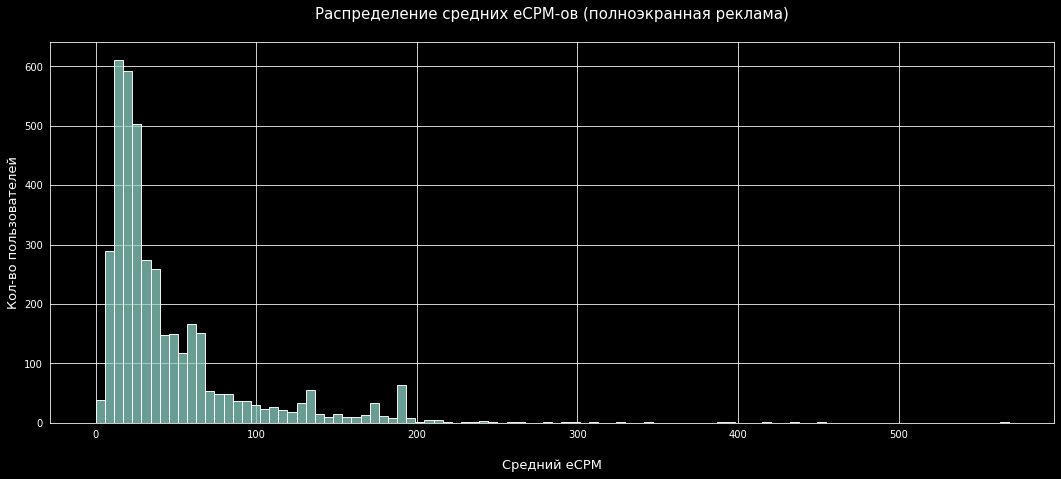

In [203]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_int, bins=100)
sns.set_style("darkgrid")
plt.style.use('dark_background')
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во пользователей', fontsize=13)
plt.title('Распределение средних eCPM-ов (полноэкранная реклама)\n', fontsize=15)
plt.show()

Абсолютное большинство пользователей имеют средний eCPM меньше 50. При этом на гистограмме мы видим длинный правый хвост: у единичных пользователей средний eCPM в разы выше. Скорее всего это связано с временем нахождения в игре.

#### Горизонтальный баннер


In [204]:
eCPM_mean_banner = df_new[df_new['ad_type'] == 'banner'].groupby('profile_id')['eCPM'].agg('mean').reset_index()

In [205]:
eCPM_mean_banner['eCPM'].describe()

count    3508.000000
mean        1.157111
std         1.867792
min         0.013930
25%         0.322804
50%         0.583002
75%         1.297329
max        43.021387
Name: eCPM, dtype: float64

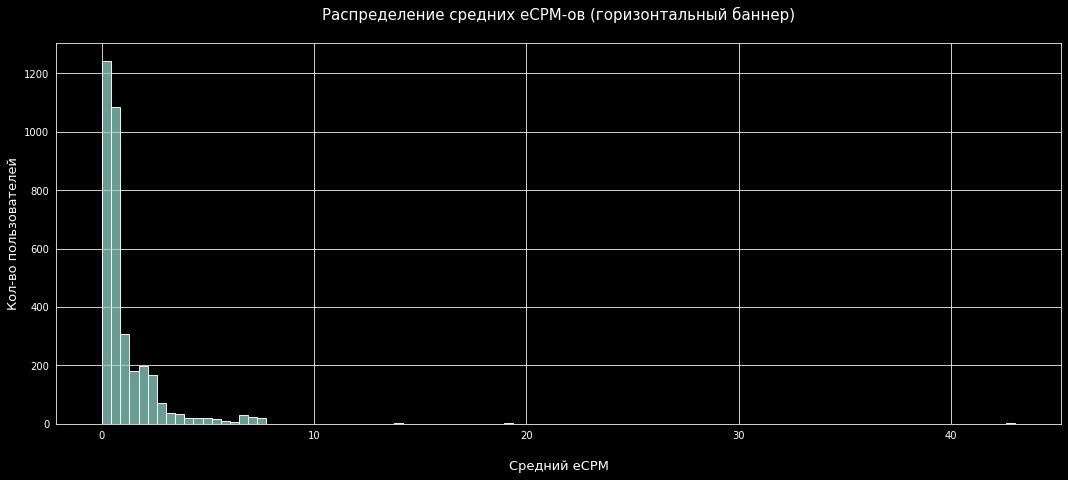

In [206]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_banner, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во пользователей', fontsize=13)
plt.title('Распределение средних eCPM-ов (горизонтальный баннер)\n', fontsize=15)
plt.show()

eCPM горизонтального банера на много меньше чем у полноэкранной рекламы. Здесь абсолютое большинство имеют средний ePCM меньше 1$.

#### Видео (которое юзер смотрит по желанию)

In [207]:
eCPM_mean_rv = df_new[df_new['ad_type'] == 'rv'].groupby('profile_id')['eCPM'].agg('mean').reset_index()

In [208]:
eCPM_mean_rv['eCPM'].describe()

count    1324.000000
mean       80.502004
std        79.154906
min         0.223222
25%        28.240000
50%        46.019935
75%        98.067206
max       808.294820
Name: eCPM, dtype: float64

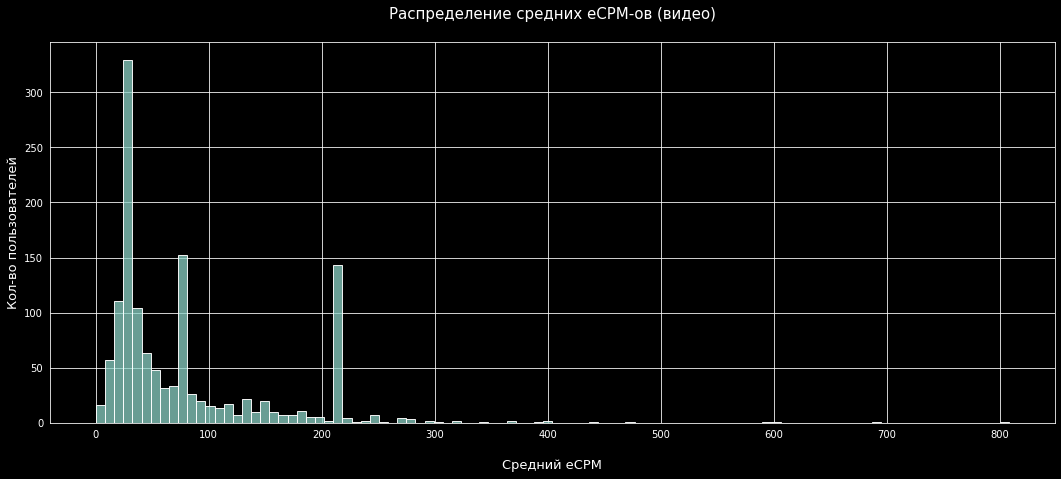

In [209]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_rv, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во пользователей', fontsize=13)
plt.title('Распределение средних eCPM-ов (видео)\n', fontsize=15)
plt.show()

У видео, которое юзер смотрит по желанию, самый большой средний eCPM. При этом медианное значение дохода за 1000 показов лежит в районе 45.

#### Длинна и количество сессий юзеров

Посмотрим как влияет на наш средний eCPM длинна сессии и количество сессий отдельного юзера.

In [210]:
eCPM_mean = df_new.groupby('profile_id')['session_length', 'eCPM'].agg({'session_length' : ['mean', 'count'], 'eCPM' : 'mean'}).reset_index()
eCPM_mean.columns = ['_'.join(col).strip() for col in eCPM_mean.columns.values]
eCPM_mean.rename(columns={"session_length_count" : "session_count"}, inplace=True)
eCPM_mean

,profile_id_,session_length_mean,session_count,eCPM_mean
0,JL00qCZH1HV,104.512035,13,3.183940
1,JL015rw9vmN,13197.701741,429,2.034417
2,JL01aCdFTJy,298.217124,39,1.027932
3,JL04ODuw9UP,696.253097,84,2.674502
4,JL06OWhBYxn,107.699927,13,0.468146
...,...,...,...,...
4221,JMLQTj4i34Y,421.661685,37,1.682470
4222,JMLY5SO7wmn,110.481255,11,3.006910
4223,JMLmauy744E,823.327000,1,23.429988
4224,JMLt54Rmui5,182.446840,3,8.102624


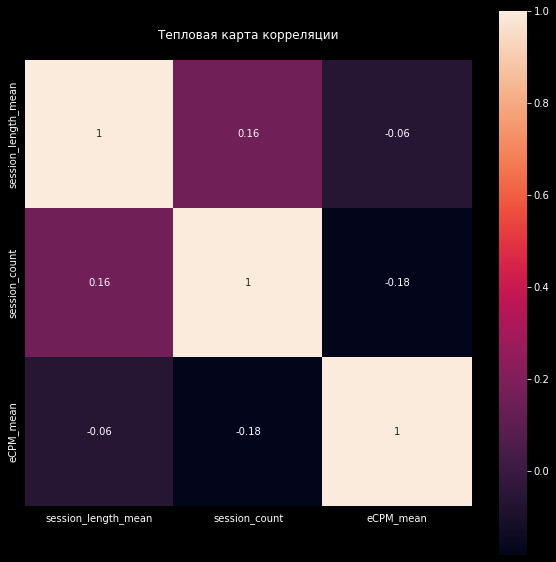

In [211]:
corr_matrix = eCPM_mean[['session_length_mean',	'session_count',	'eCPM_mean']].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, robust=True, square=True, annot=True)

plt.title('Тепловая карта корреляции\n')
plt.show()

Из карты корреляции видно что количество сессий и длинна сессии не значительно влияют на наш средний eCPM. С увеличением колличества сессий средний eCPM немного уменьшается (отрицательная корреляция). При этом видим небольшую положительную корреляцию между самим кол-вом сессий и их длинной. Это говорит о поклонниках игры, которые играют чаще и дольше. \
Следовательно наши длинные правые хвосты на гистограммах распределения eCPM являются единичными выбросами. 

#### Вывод по разделу.

Сделаем общую таблицу средних eCPM-ов.

In [212]:
eCPM_mean_median = df_new.groupby('ad_type')['eCPM'].agg(['mean', 'median','count'])
eCPM_mean_median.rename(index={'banner' : "Баннер", 'int': "Полноэкранная", 'rv': "Видео"},
                        columns={"mean": "eCPM_mean", "median": "eCPM_median", 'count' : 'events_count'}, inplace=True)
eCPM_mean_median

,eCPM_mean,eCPM_median,events_count
ad_type,,,
Баннер,0.744116,0.494196,815973
Полноэкранная,36.210813,21.398855,37610
Видео,65.051165,31.468961,6482


Из сводной таблицы видно, что самые большие значения среднего и медианного eCPM у видеовидео, которое юзер смотрит по желанию. При этом показов видео в разы меньше. \
Самые низкие показатели eCPM у баннера, приэтом показывается он в сотни раз больше. \
Полноэкранная реклама занимает средние позиции по всем параметрам.

### 2.2 Средние eCPM-ы по городам.

#### Полноэкранная реклама


In [213]:
eCPM_mean_int = df_new[(df_new['ad_type'] == 'int') & (df_new['city'] != 'unknown')].groupby('city')['eCPM'].agg('mean').reset_index()
eCPM_mean_int

,city,eCPM
0,Aberdeen,13.583285
1,Abilene,50.301282
2,Afton,29.088757
3,Akron,64.626718
4,Alameda,20.145481
...,...,...
864,Youngstown,52.209237
865,Ypsilanti,58.960980
866,Yukon,12.503681
867,Yuma,13.281538


In [214]:
eCPM_mean_int['eCPM'].describe()

count    869.000000
mean      44.829423
std       44.671766
min        2.750576
25%       19.411409
50%       31.001778
75%       52.142344
max      437.039882
Name: eCPM, dtype: float64

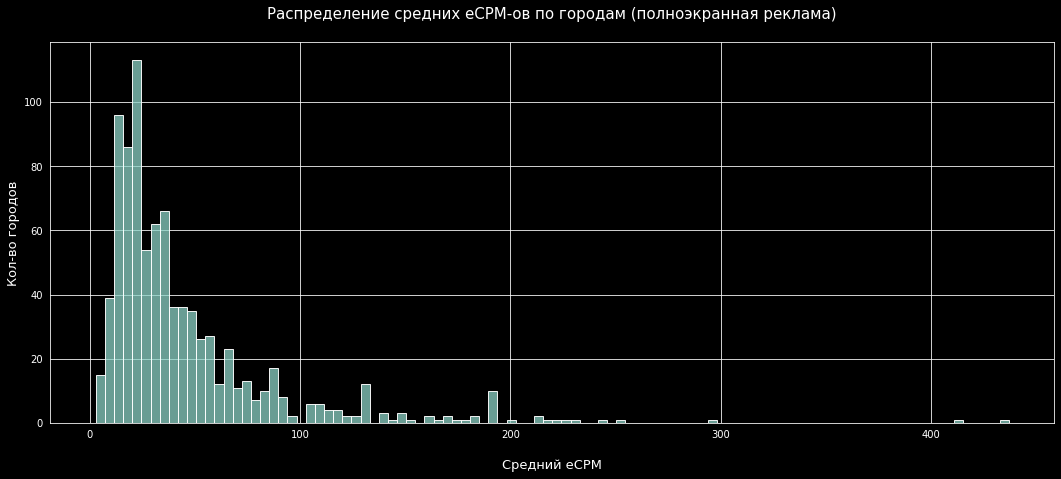

In [215]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_int, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Распределение средних eCPM-ов по городам (полноэкранная реклама)\n', fontsize=15)
plt.show()

#### Горизонтальный баннер

In [216]:
eCPM_mean_banner = df_new[(df_new['ad_type'] == 'banner') & (df_new['city'] != 'unknown')].groupby('city')['eCPM'].agg('mean').reset_index()

In [217]:
eCPM_mean_banner['eCPM'].describe()

count    856.000000
mean       1.026122
std        1.439121
min        0.029317
25%        0.342273
50%        0.568364
75%        1.088064
max       19.326435
Name: eCPM, dtype: float64

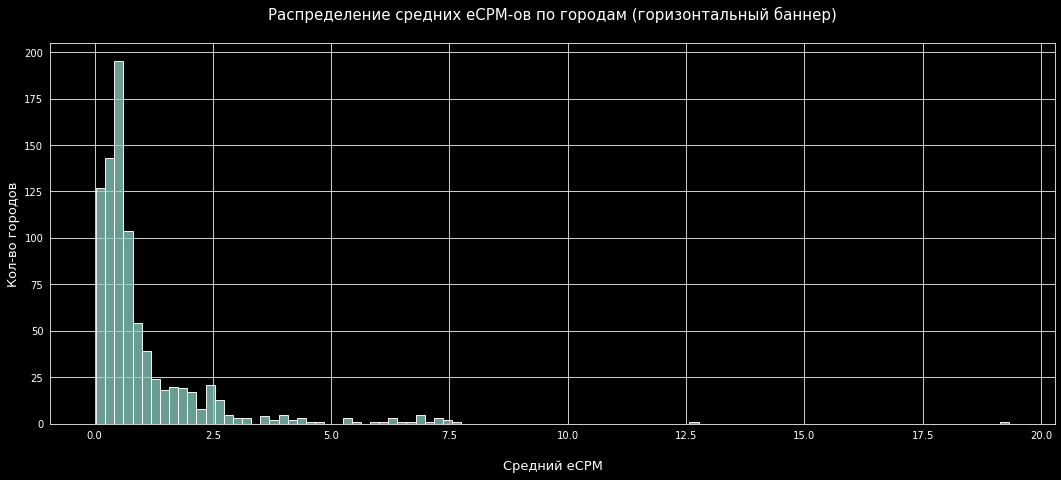

In [218]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_banner, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Распределение средних eCPM-ов по городам (горизонтальный баннер)\n', fontsize=15)
plt.show()

#### Видео (которое юзер смотрит по желанию)

In [219]:
eCPM_mean_rv = df_new[(df_new['ad_type'] == 'rv') & (df_new['city'] != 'unknown')].groupby('city')['eCPM'].agg('mean').reset_index()

In [220]:
eCPM_mean_rv['eCPM'].describe()

count    454.000000
mean      80.532356
std       76.601650
min        3.339551
25%       28.240000
50%       55.959567
75%      104.940871
max      808.294820
Name: eCPM, dtype: float64

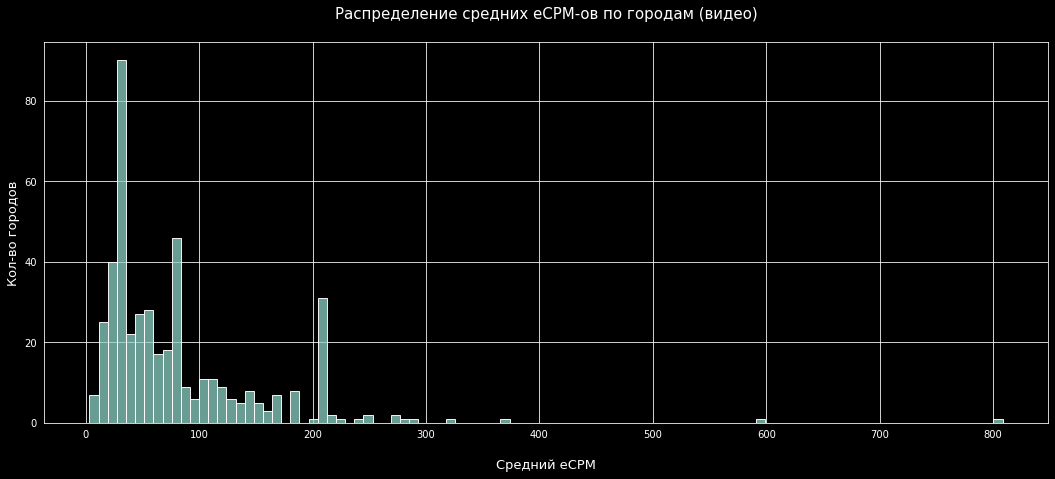

In [221]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_rv, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Распределение средних eCPM-ов по городам (видео)\n', fontsize=15)
plt.show()

#### Вывод по разделу

Все три вида рекламы сильно разнятся по цене в зависимости от города показа. При этом в топ по цене выбиваются разные города если градировать по типу рекламы. \
Выведем города с топовыми ценами. 

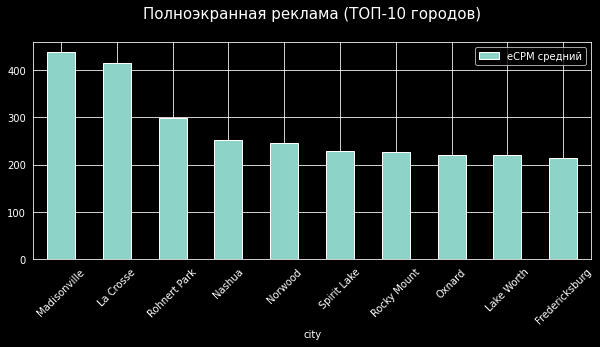

In [222]:
eCPM_mean_int.sort_values(by='eCPM',ascending=False).head(10).plot(x='city', kind='bar', figsize=(10,4))
plt.title('Полноэкранная реклама (ТОП-10 городов)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 45)
plt.show()

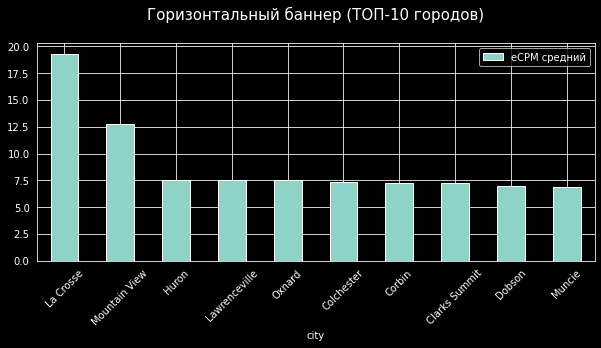

In [223]:
eCPM_mean_banner.sort_values(by='eCPM',ascending=False).head(10).plot(x='city', kind='bar', figsize=(10,4))
plt.title('Горизонтальный баннер (ТОП-10 городов)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 45)
plt.show()

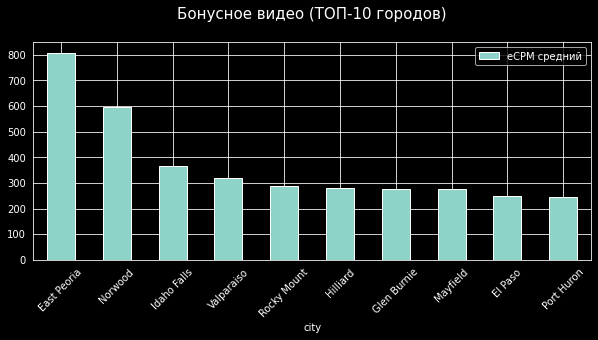

In [224]:
eCPM_mean_rv.sort_values(by='eCPM',ascending=False).head(10).plot(x='city', kind='bar', figsize=(10,4))
plt.title('Бонусное видео (ТОП-10 городов)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 45)
plt.show()

### 2.3 Средние eCPM-ы по версиям ОС.

In [225]:
eCPM_mean_int = df_new[df_new['ad_type'] == 'int'].groupby('os_version')['eCPM'].agg('mean').reset_index()
eCPM_mean_int

,os_version,eCPM
0,10,31.216643
1,11,33.471794
2,12,42.391070
3,5.0.2,14.969333
4,6.0.1,13.172003
5,7.0,39.266162
6,7.1.1,18.232767
7,7.1.2,11.964031
8,8.0.0,20.030134
9,8.1.0,17.694561


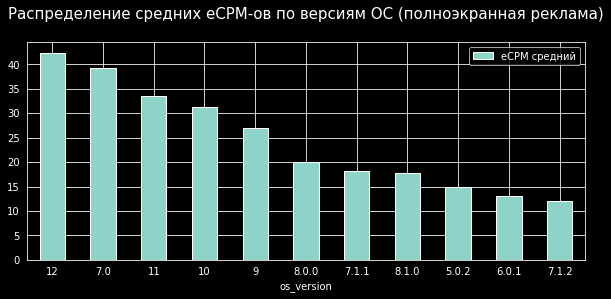

In [226]:
eCPM_mean_int.sort_values(by='eCPM',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Распределение средних eCPM-ов по версиям ОС (полноэкранная реклама)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

In [227]:
eCPM_mean_banner = df_new[df_new['ad_type'] == 'banner'].groupby('os_version')['eCPM'].agg('mean').reset_index()

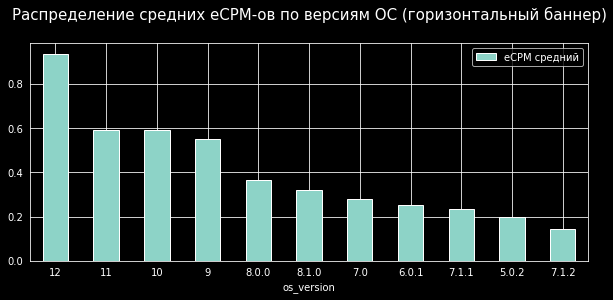

In [228]:
eCPM_mean_banner.sort_values(by='eCPM',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Распределение средних eCPM-ов по версиям ОС (горизонтальный баннер)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

In [229]:
eCPM_mean_rv = df_new[df_new['ad_type'] == 'rv'].groupby('os_version')['eCPM'].agg('mean').reset_index()

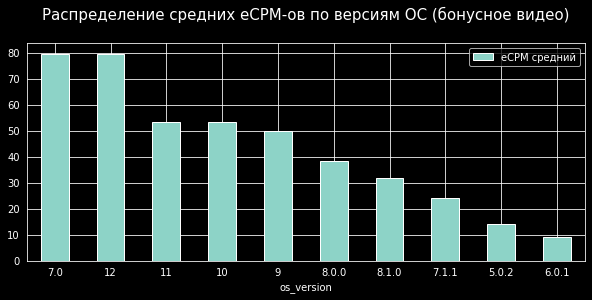

In [230]:
eCPM_mean_rv.sort_values(by='eCPM',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Распределение средних eCPM-ов по версиям ОС (бонусное видео)\n', fontsize=15)
plt.legend(['eCPM средний'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

В топе по среднему eCPM более новые операционные системы (10,11,12). Это логично из-за их большого количества, ведь они предустанавливаются на новые гаджеты и машины. \
Так же в ТОП попала система 7. Это обусловленно тем, что она преобладает на более старой технике, которой так же достаточно много на сегодняшний день.

### 2.4 Суммарные доходы по городам

#### Полноэкранная реклама

In [251]:
revenue_sum_int = df_new[(df_new['ad_type'] == 'int') & (df_new['city'] != 'unknown')] \
                  .groupby('city')['revenue'].agg('sum').reset_index()
revenue_sum_int

,city,revenue
0,Aberdeen,0.081500
1,Abilene,0.402410
2,Afton,0.727219
3,Akron,1.680295
4,Alameda,0.020145
...,...,...
864,Youngstown,0.626511
865,Ypsilanti,2.771166
866,Yukon,0.637688
867,Yuma,0.053126


In [239]:
revenue_sum_int['revenue'].describe()

count    869.000000
mean       0.992543
std        2.179647
min        0.002891
25%        0.105106
50%        0.318778
75%        0.884545
max       25.674272
Name: revenue, dtype: float64

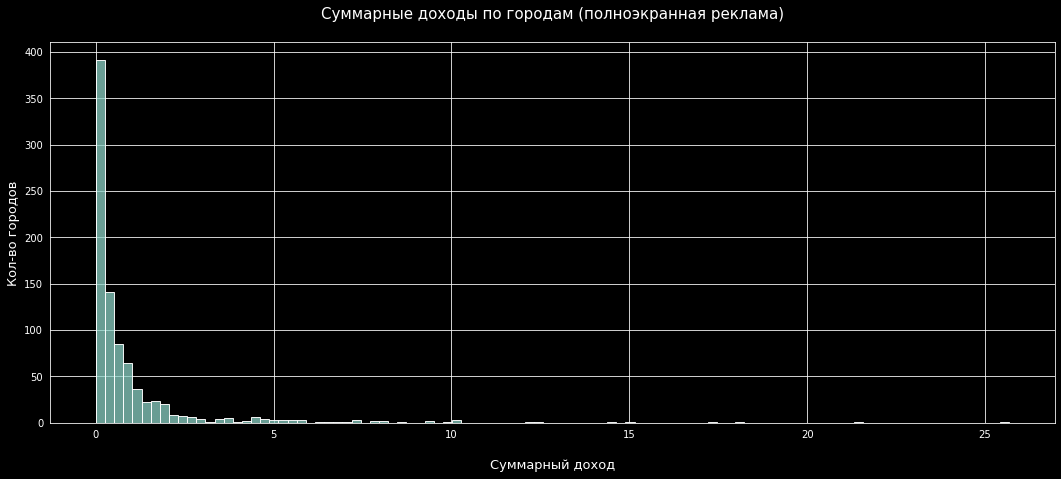

In [249]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_sum_int, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам (полноэкранная реклама)\n', fontsize=15)
plt.show()

Посмотрим суммарные доходы от полноэкранной рекламы до 75-квантиля, для лучшего понимания картины доходов. 

In [256]:
q = revenue_sum_int['revenue'].quantile(0.75)
revenue_q = revenue_sum_int[revenue_sum_int['revenue'] < q]

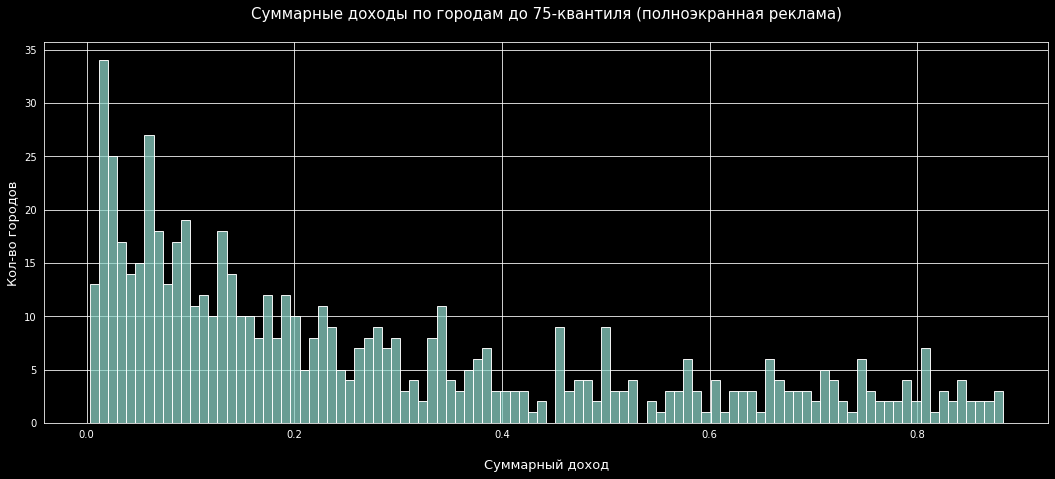

In [250]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_q, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам до 75-квантиля (полноэкранная реклама)\n', fontsize=15)
plt.show()

#### Горизонтальный баннер

In [252]:
revenue_sum_banner = df_new[(df_new['ad_type'] == 'banner') & (df_new['city'] != 'unknown')] \
                  .groupby('city')['revenue'].agg('sum').reset_index()

In [254]:
revenue_sum_banner['revenue'].describe()

count    856.000000
mean       0.435164
std        1.078178
min        0.000031
25%        0.023070
50%        0.102468
75%        0.353011
max       12.708617
Name: revenue, dtype: float64

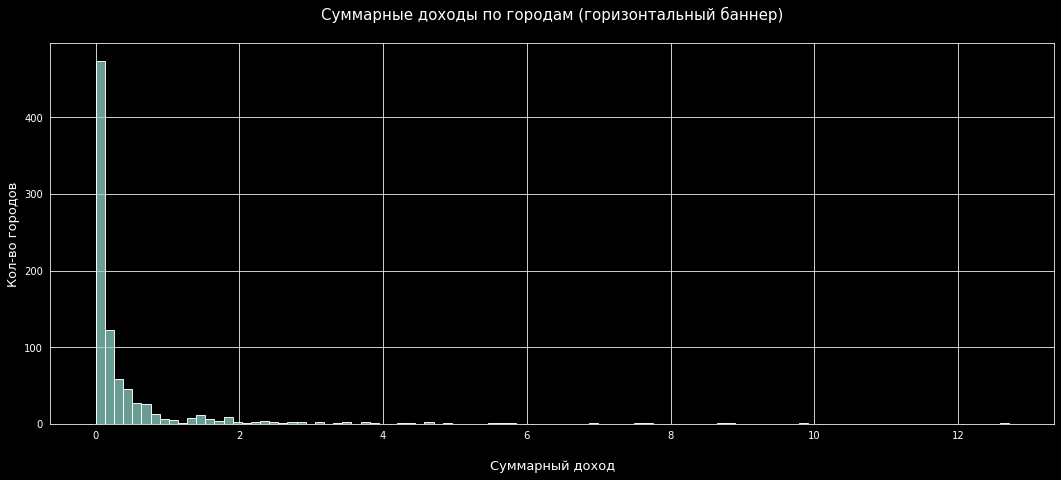

In [255]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_sum_banner, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам (горизонтальный баннер)\n', fontsize=15)
plt.show()

In [257]:
q = revenue_sum_banner['revenue'].quantile(0.75)
revenue_q = revenue_sum_banner[revenue_sum_banner['revenue'] < q]

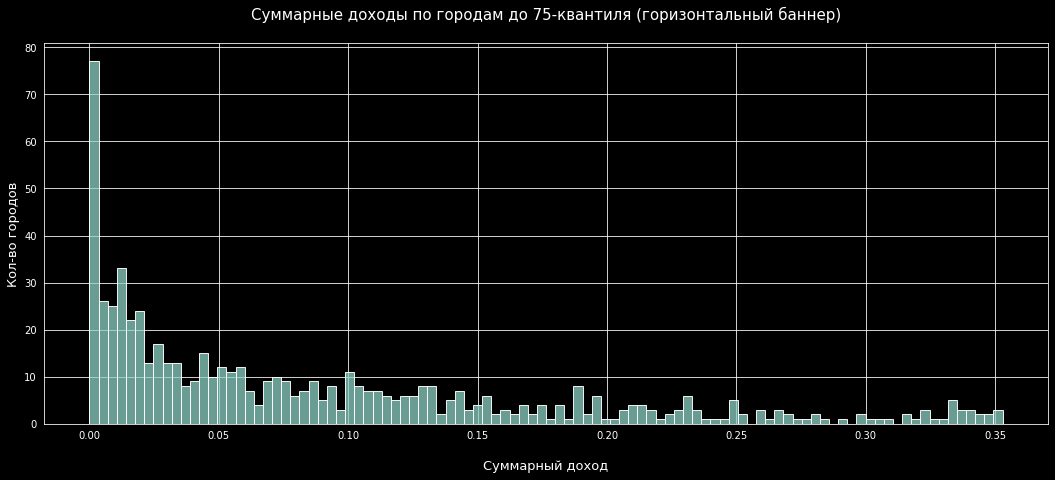

In [259]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_q, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам до 75-квантиля (горизонтальный баннер)\n', fontsize=15)
plt.show()

#### Видео (которое юзер смотрит по желанию)

In [261]:
revenue_sum_rv = df_new[(df_new['ad_type'] == 'rv') & (df_new['city'] != 'unknown')] \
                  .groupby('city')['revenue'].agg('sum').reset_index()

In [262]:
revenue_sum_rv['revenue'].describe()

count    454.000000
mean       0.627604
std        1.218373
min        0.004075
25%        0.080640
50%        0.211700
75%        0.643971
max       11.389241
Name: revenue, dtype: float64

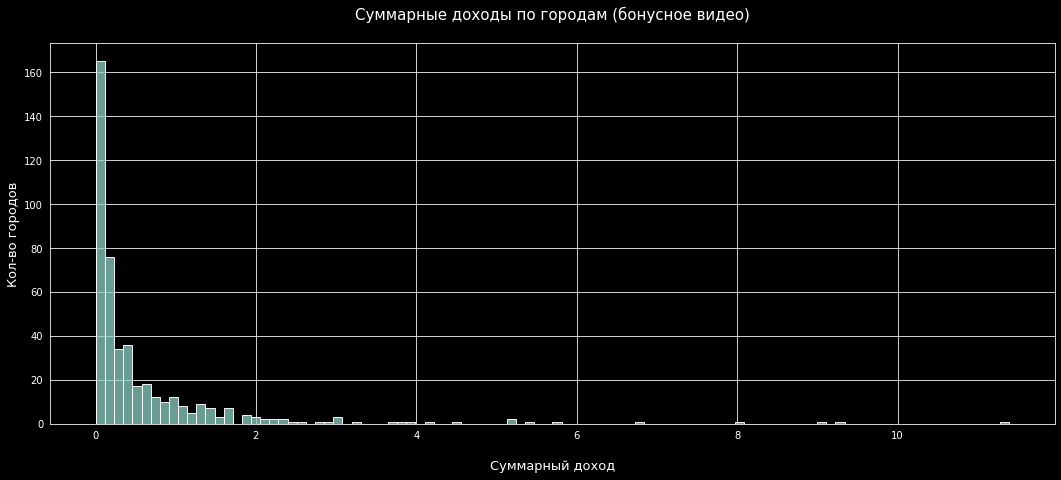

In [263]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_sum_rv, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам (бонусное видео)\n', fontsize=15)
plt.show()

In [264]:
q = revenue_sum_rv['revenue'].quantile(0.75)
revenue_q = revenue_sum_rv[revenue_sum_rv['revenue'] < q]

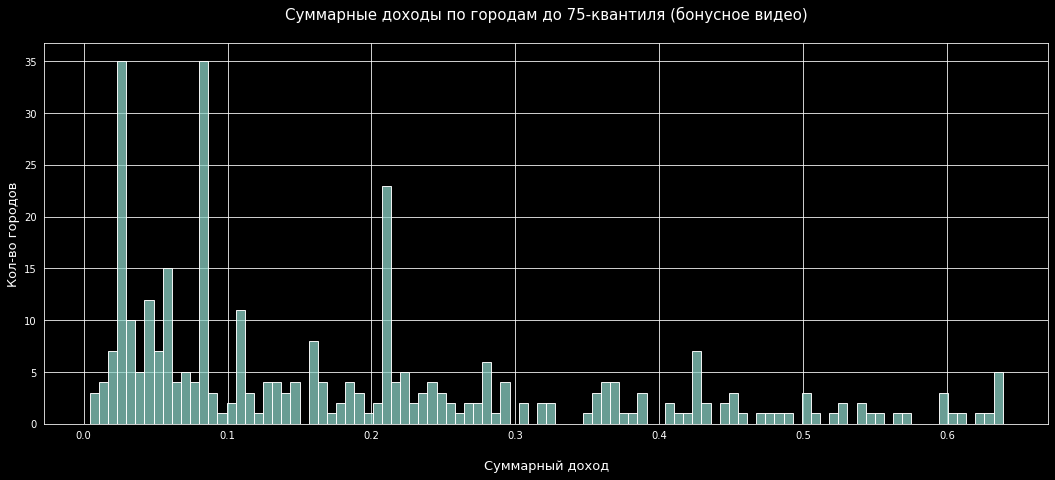

In [265]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'revenue', data = revenue_q, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам до 75-квантиля (бонусное видео)\n', fontsize=15)
plt.show()

#### Вывод по разделу

Посмотрим на ТОП-5 городов с самыми большими сумарными доходами.

Полноэкранная реклама

In [272]:
revenue_sum_int.sort_values(by='revenue',ascending=False).head(5)

,city,revenue
550,New York,25.674272
357,Indianapolis,21.534431
152,Cleveland,18.112861
506,Minneapolis,17.286339
131,Charlotte,14.940739


Горизонтальный баннер

In [273]:
revenue_sum_banner.sort_values(by='revenue',ascending=False).head(5)

,city,revenue
552,New York,12.708617
366,Indianapolis,9.789215
739,Spokane,8.862484
355,Houston,8.664916
510,Minneapolis,7.629354


Бонусное видео

In [274]:
revenue_sum_rv.sort_values(by='revenue',ascending=False).head(5)

,city,revenue
191,Houston,11.389241
273,Minneapolis,9.319597
296,New York,9.071508
312,Oklahoma City,8.045251
88,Cleveland,6.797868


New York, Minneapolis, Indianapolis, Houston - города с самыми большими доходами от показа рекламы.

### 2.5 Суммарные доходы по версиям ОС

In [275]:
revenue_sum_int = df_new[(df_new['ad_type'] == 'int') & (df_new['city'] != 'unknown')] \
                  .groupby('os_version')['revenue'].agg('sum').reset_index()
revenue_sum_int

,os_version,revenue
0,10,111.733425
1,11,240.061200
2,12,455.931350
3,6.0.1,0.113062
4,7.0,1.315455
5,7.1.1,0.142942
6,7.1.2,0.511106
7,8.0.0,4.654306
8,8.1.0,3.352236
9,9,44.704851


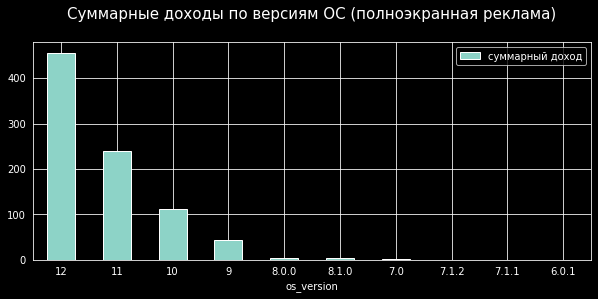

In [276]:
revenue_sum_int.sort_values(by='revenue',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Суммарные доходы по версиям ОС (полноэкранная реклама)\n', fontsize=15)
plt.legend(['суммарный доход'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

In [277]:
revenue_sum_banner = df_new[(df_new['ad_type'] == 'banner') & (df_new['city'] != 'unknown')] \
                  .groupby('os_version')['revenue'].agg('sum').reset_index()

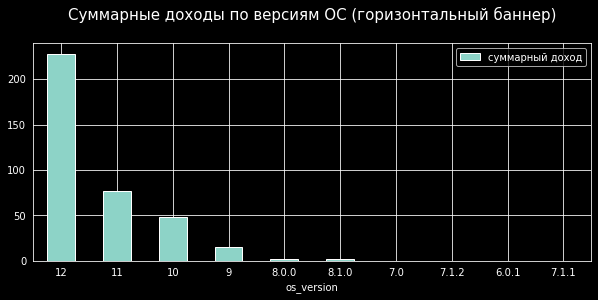

In [280]:
revenue_sum_banner.sort_values(by='revenue',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Суммарные доходы по версиям ОС (горизонтальный баннер)\n', fontsize=15)
plt.legend(['суммарный доход'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

In [281]:
revenue_sum_rv = df_new[(df_new['ad_type'] == 'rv') & (df_new['city'] != 'unknown')] \
                  .groupby('os_version')['revenue'].agg('sum').reset_index()

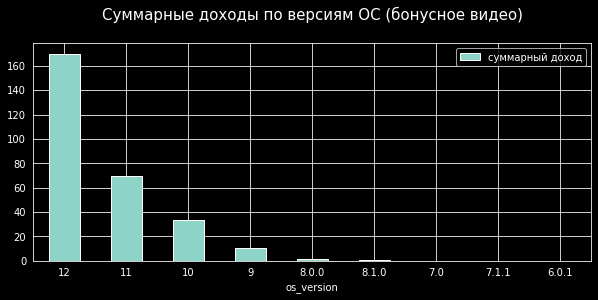

In [282]:
revenue_sum_rv.sort_values(by='revenue',ascending=False).plot(x='os_version', kind='bar', figsize=(10,4))
plt.title('Суммарные доходы по версиям ОС (бонусное видео)\n', fontsize=15)
plt.legend(['суммарный доход'],loc='upper right')
plt.xticks(rotation = 0)
plt.show()

Абсолютные лидеры по суммарным доходам операционные системы нового поколения: 10, 11, 12. Такие показатели достигнуты ввиду их большого количества, по сравнению с другими старыми ОС.

### 2.5 Средние eCPM-ы по городам с учетом статистической значимости.

#### Полноэкранная реклама

Построим диаграмму размаха, чтобы отсеять выбросы.

In [283]:
eCPM_mean_int = df_new[(df_new['ad_type'] == 'int') & (df_new['city'] != 'unknown')] \
                .groupby('city')['eCPM'].agg('mean').reset_index()

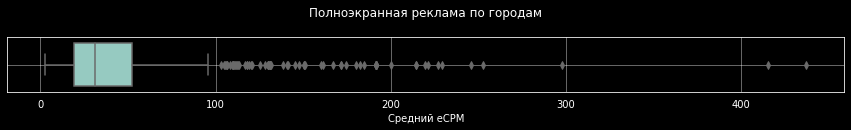

In [303]:
plt.figure(figsize=(15,1))
sns.boxplot(data=eCPM_mean_int, x='eCPM')

plt.title(label='Полноэкранная реклама по городам\n')
plt.xlabel("Средний eCPM")
plt.grid(alpha=0.5)
plt.show()

Посмотрим на распределение средних eCPM-ов без выбросов

In [306]:
eCPM_mean_int = eCPM_mean_int[eCPM_mean_int['eCPM'] < 100]

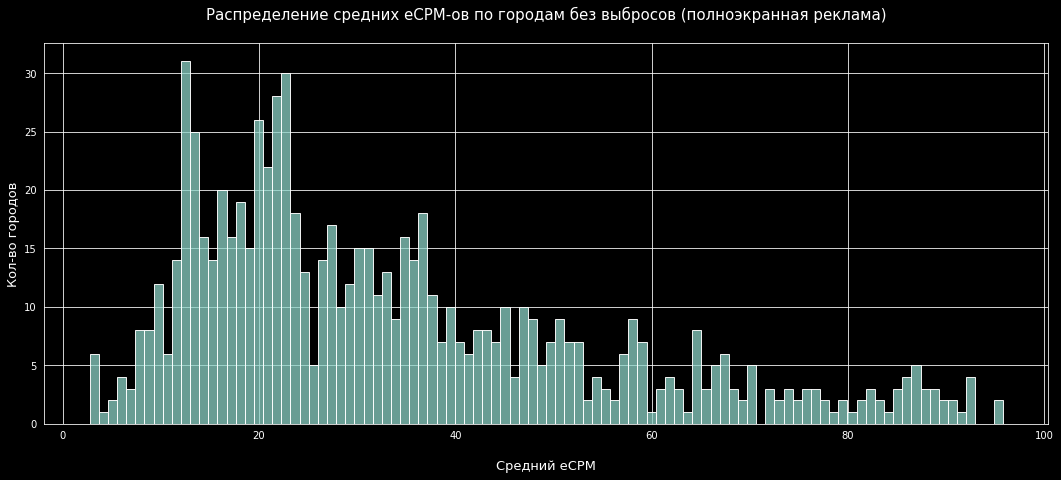

In [308]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_int, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Распределение средних eCPM-ов по городам без выбросов (полноэкранная реклама)\n', fontsize=15)
plt.show()

#### Горизонтальный баннер

In [309]:
eCPM_mean_banner = df_new[(df_new['ad_type'] == 'banner') & (df_new['city'] != 'unknown')] \
                    .groupby('city')['eCPM'].agg('mean').reset_index()

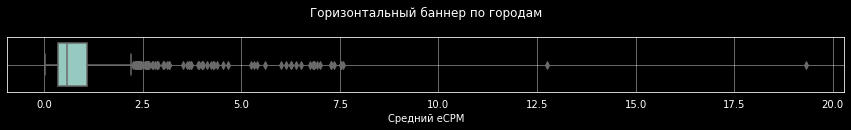

In [310]:
plt.figure(figsize=(15,1))
sns.boxplot(data=eCPM_mean_banner, x='eCPM')

plt.title(label='Горизонтальный баннер по городам\n')
plt.xlabel("Средний eCPM")
plt.grid(alpha=0.5)
plt.show()

In [311]:
eCPM_mean_banner = eCPM_mean_banner[eCPM_mean_banner['eCPM'] < 2.5]

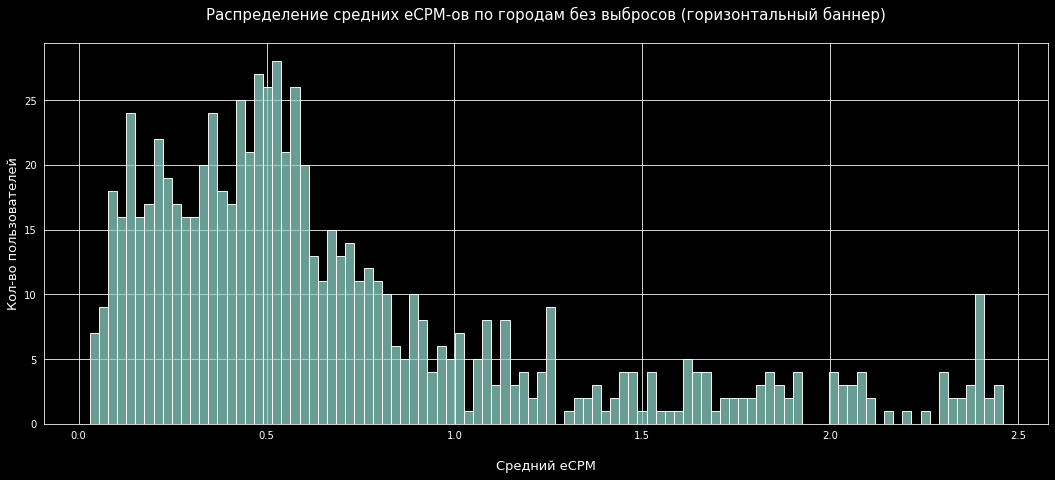

In [313]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_banner, bins=100)
plt.xlabel('\nСредний eCPM', fontsize=13)
plt.ylabel('Кол-во пользователей', fontsize=13)
plt.title('Распределение средних eCPM-ов по городам без выбросов (горизонтальный баннер)\n', fontsize=15)
plt.show()

#### Видео (которое юзер смотрит по желанию)

In [314]:
eCPM_mean_rv = df_new[(df_new['ad_type'] == 'rv') & (df_new['city'] != 'unknown')] \
              .groupby('city')['eCPM'].agg('mean').reset_index()

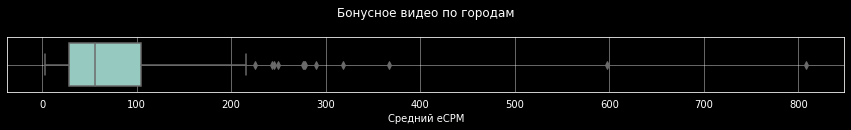

In [315]:
plt.figure(figsize=(15,1))
sns.boxplot(data=eCPM_mean_rv, x='eCPM')

plt.title(label='Бонусное видео по городам\n')
plt.xlabel("Средний eCPM")
plt.grid(alpha=0.5)
plt.show()

In [316]:
eCPM_mean_rv = eCPM_mean_rv[eCPM_mean_rv['eCPM'] < 230]

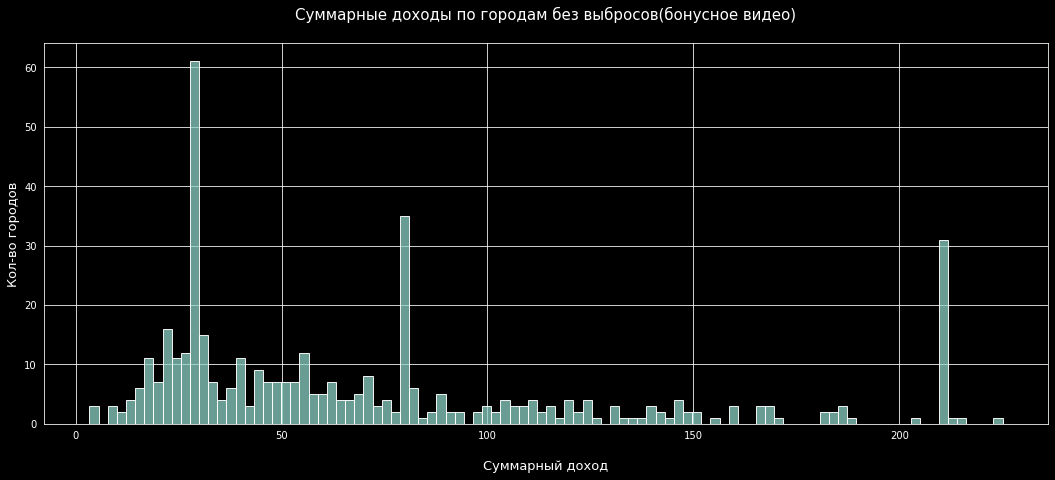

In [320]:
plt.figure(figsize=(18, 7))
sns.histplot(x = 'eCPM', data = eCPM_mean_rv, bins=100)
plt.xlabel('\nСуммарный доход', fontsize=13)
plt.ylabel('Кол-во городов', fontsize=13)
plt.title('Суммарные доходы по городам без выбросов(бонусное видео)\n', fontsize=15)
plt.show()

## 3. Заключение

В процессе знакомства с датафреймом мы ранее определили, что только **62% доходов содержат информации о городе пользователя**. \
Промежуточные выводы так же были сделаны в процессе работы. \
Осталось посмотреть: зависит ли eCPM от времени дня.

### 3.1 Зависимость eCPM от времени суток.

Определим временной диапазон за который нам предоставленны данные

In [322]:
df_new.event_datetime.min(), df_new.event_datetime.max()

(Timestamp('2022-01-29 17:42:32'), Timestamp('2022-02-07 23:59:59'))

Для точности анализа уберём лишние часы

In [325]:
df_new = df_new.query('event_datetime > "2022-01-29 23:59:59"')

Добавим новый столбец с часами

In [326]:
df_new['event_hour'] = pd.to_datetime(df_new['event_datetime']).dt.hour

In [327]:
df_new.head()

,profile_id,os_version,event_datetime,city,ad_type,session_length,revenue,network_name,eCPM,event_hour
0,JLjpGzDHBQm,11,2022-02-04 20:02:28,Norwalk,banner,705.88070,0.000510,Google AdMob,0.510313,20
1,JLjpGzDHBQm,11,2022-02-04 20:02:45,Norwalk,banner,722.65120,0.000510,Google AdMob,0.510313,20
2,JLkVacrzHY6,11,2022-02-05 17:53:05,Charlotte,banner,431.81290,0.002386,APPLOVIN_EXCHANGE,2.386163,17
3,JMC6wG3cX0f,10,2022-02-06 17:09:01,Cocoa,int,125.94960,0.013894,AppLovin,13.893784,17
4,JLzWWTJfi1b,10,2022-02-06 17:15:38,unknown,banner,12.71129,0.006828,Google AdMob,6.827570,17


Проанализируем зависимость от времени суток

#### Полноэкранная реклама

In [329]:
eCPM_mean_int = df_new[df_new['ad_type'] == 'int'].groupby('event_hour')['eCPM'].agg('mean').reset_index()
eCPM_mean_int

,event_hour,eCPM
0,0,34.641341
1,1,35.804109
2,2,36.142327
3,3,36.435454
4,4,33.636707
5,5,38.686139
6,6,40.104725
7,7,34.355289
8,8,36.769996
9,9,39.818551


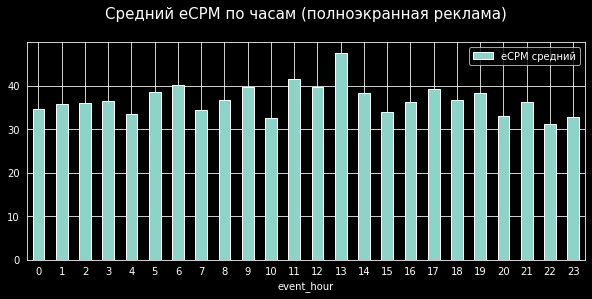

In [336]:
eCPM_mean_int.plot(x='event_hour', kind='bar', figsize=(10,4))
plt.title('Средний eCPM по часам (полноэкранная реклама)\n', fontsize=15)
plt.xticks(rotation = 0)
plt.legend(['eCPM средний'],loc='upper right')
plt.show()

#### Горизонтальный баннер

In [337]:
eCPM_mean_banner = df_new[df_new['ad_type'] == 'banner'].groupby('event_hour')['eCPM'].agg('mean').reset_index()

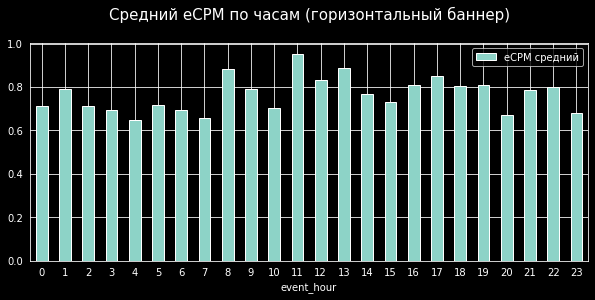

In [338]:
eCPM_mean_banner.plot(x='event_hour', kind='bar', figsize=(10,4))
plt.title('Средний eCPM по часам (горизонтальный баннер)\n', fontsize=15)
plt.xticks(rotation = 0)
plt.legend(['eCPM средний'],loc='upper right')
plt.show()

#### Видео (которое юзер смотрит по желанию)

In [343]:
eCPM_mean_rv = df_new[df_new['ad_type'] == 'rv'].groupby('event_hour')['eCPM'].agg('mean').reset_index()

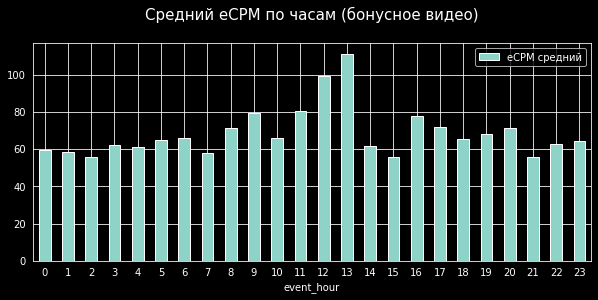

In [344]:
eCPM_mean_rv.plot(x='event_hour', kind='bar', figsize=(10,4))
plt.title('Средний eCPM по часам (бонусное видео)\n', fontsize=15)
plt.xticks(rotation = 0)
plt.legend(['eCPM средний'],loc='upper right')
plt.show()

Кардинально средний eCPM не меняется в зависимости от времени суток. При этом к середине дня (в районе 13 часов) наблюдается небольшой рост у всех видов рекламы, затем значения снижаются.